# Code demonstration : Quantum Kernel Methods

## Classification on MNIST dataset

In [ ]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


### 1. Load and preprocess the dataset

We focus on the digits 3 and 6 in the MNIST dataset, forming a binary classification problem.

Then,  Principal Component Analysis is applied to reduce the feature dimension of the images, minimizing the number of required qubits for encoding. 

The compressed features are normalized to align with the periodicity of the quantum feature mapping.


In [2]:
def load_mnist(n_qubit):
    # Load MNIST dataset from OpenML
    mnist = fetch_openml("mnist_784", version=1)
    X, y = mnist.data, mnist.target

    # Filter for digits 3 and 6
    mask_36 = (y == "3") | (y == "6")
    X, y = X[mask_36], y[mask_36]

    # Convert labels to binary
    y = np.where(y == "3", 0, 1)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_qubit) 
    X_reduced = pca.fit_transform(X)

    # Normalize features to [0, 2π]
    scaler = StandardScaler().fit(X_reduced)
    X_scaled = scaler.transform(X_reduced)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    return X_train, X_test, y_train, y_test

n_qubit = 8
X_train, X_test, y_train, y_test = load_mnist(n_qubit)

To better understand the structure of the dataset, we visualize the training data using t-SNE.

C:\Users\ho.aabela\AppData\Local\Temp\ipykernel_24512\983146513.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


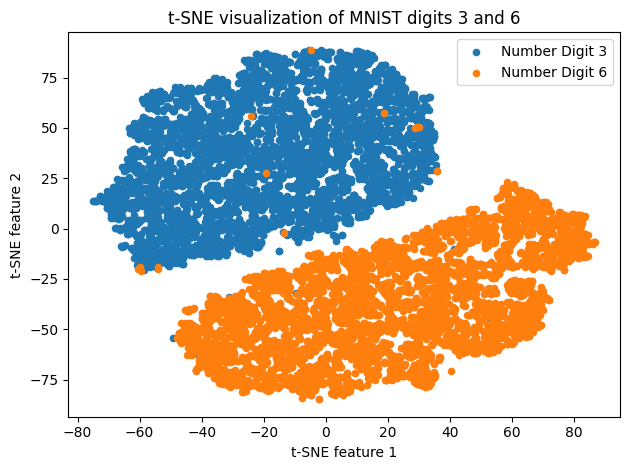

In [ ]:
def visualize_dataset(X,y):
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)

    label2name = {0: "Digit 3", 1: "Digit 6"}
    mnist_tsne = tsne.fit_transform(X)

    for label in np.unique(y):
        indices = y == label
        plt.scatter(
            mnist_tsne[indices, 0], 
            mnist_tsne[indices, 1], 
            label=f'Number {label2name[label]}',
            s=20
        )

    # Add legend and title
    plt.title("t-SNE visualization of MNIST digits 3 and 6")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_dataset(X_train, y_train)

### 2. Define tu quantum feature mapping

We use angle embedding as the quantum feature mapping method

In [5]:
dev = qml.device("default.qubit", wires=n_qubit)

@qml.qnode(dev)
def kernel(x1, x2, n_qubit):
    # Angle embedding of the first data point x1
    qml.AngleEmbedding(x1, wires=range(n_qubit))
    # Apply the adjoint (inverse) of the feature map for x2
    qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubit))
    # Measure the probability of being in the |0...0⟩ state
    return qml.expval(qml.Projector([0]*n_qubit, wires=range(n_qubit)))

### 3. Construct the quantum kernel

Using the quantum kernel, we construct the kernel matrix by computing the kernel values for all pairs of samples

In [7]:
def kernel_mat(A, B):
    mat = []
    for a in A:
        row = []
        for b in B:
            row.append(kernel(a, b, n_qubit))
            mat.append(row)
    return np.array(mat)

Next, we visualize the quantum kernel matrix to gain insight into its structure.

20 10


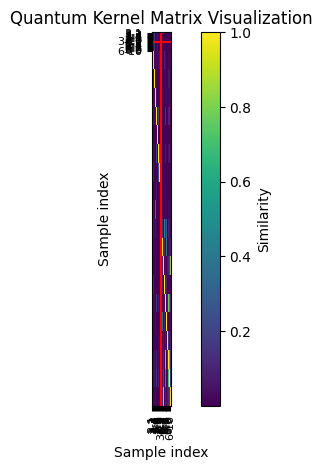

In [ ]:
def visualize_kernel(X, y, n_sample):
    X_vis = []
    for label in np.unique(y):
        index = y == label
        X_vis.append(X[index][:n_sample])

    X_vis = np.concatenate(X_vis, axis=0)
    n_sample_per_class = len(X_vis) // 2

    sim_mat = kernel_mat(X_vis, X_vis)
    np.save("02sim_mat.npy", sim_mat)

    plt.imshow(sim_mat, cmap="viridis", interpolation="nearest")

    # Add color bar to show the scale
    plt.colorbar(label="Similarity")

    plt.axhline(n_sample_per_class - 0.5, color='red', linewidth=1.5)
    plt.axvline(n_sample_per_class - 0.5, color='red', linewidth=1.5)

    xticks = yticks = np.arange(0, len(X_vis))
    xticks_labels = [f"3-{i+1}" if i < n_sample_per_class else f"6-{i - n_sample_per_class +1}" for i in range(len(X_vis))]
    yticks_labels = xticks_labels

    plt.xticks(xticks, xticks_labels, rotation=90, fontsize=8)
    plt.yticks(yticks, yticks_labels, fontsize=8)

    plt.title("Quantum Kernel Matrix Visualization")
    plt.xlabel("Sample index")
    plt.ylabel("Sample index")

    plt.tight_layout()
    plt.show()

visualize_kernel(X_train, y_train, n_sample=10)

### 4. Train and evaluate the SVM classifier

To achieve higher classification accuracy, we build, train, and evaluate the SVM classifier with the quantum kernel matrix.

In [11]:
svm = SVC(kernel=kernel_mat)
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, pred))

KeyboardInterrupt: 

To further analyze how the performance of the SVM with a quantum kernel depends on the size of the training dataset, we vary the number of training samples from 10 to 100 in increments of 10.

In [ ]:
svm = SVC(kernel="precomputed")
n_sample_max = 100
X_train_sample = []
y_train_sample = []

for label in np.unique(y_train):
    index = y_train == label
    X_train_sample.append(X_train[index][:n_sample_max])
    y_train_sample.append(y_train[index][:n_sample_max])

X_train_sample = np.concatenate(X_train_sample, axis=0)
y_train_sample = np.concatenate(y_train_sample, axis=0)
kernel_mat_train = kernel_mat(X_train_sample, X_train_sample)
kernel_mat_test = kernel_mat(X_test, X_train_sample)

accuracies = []
n_samples = []

for n_sample in range(10, n_sample_max + 1, 10):
    class1_indices = np.arange(n_sample)
    class2_indices = np.arange(n_sample_max, n_sample_max + n_sample)
    selected_indices = np.concatenate([class1_indices, class2_indices])

    svm.fit(kernel_mat_train[np.ix_(selected_indices, selected_indices)], np.concatenate([y_train_sample[:n_sample], y_train_sample[n_sample_max:n_sample_max + n_sample]]))
    pred = svm.predict(np.concatenate([kernel_mat_test[:,:n_sample_max+n_sample]], axis=1))
    accuracies.append(accuracy_score(y_test, pred))
    n_samples.append(n_sample)

plt.plot(n_samples, accuracies, marker='o')
plt.title("Classification Accuracy vs. Number of Training Samples")
plt.xlabel("Number of Training Samples")
plt.ylabel("Classification Accuracy")
plt.xticks(n_samples, n_samples)
plt.grid()
plt.tight_layout()
plt.show()